In [1]:
# change directory
import os
rootdir = os.path.dirname(os.getcwd())
os.chdir(rootdir)

# import third libs for data
import datetime as dt
import numpy as np
import pandas as pd

# make imports
from utils import rendering as vw
from benchmarks import schema as sch
from config import DATA_DIR

In [2]:
benchmarkid = 'Dialysis2021'
dbmsid = 'MySql'

In [3]:
ganttview = vw.GanttView(benchmarkid, dbmsid)
ganttview

In [4]:
# f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
# ganttview.plot('w2018%21', '%CEMP%', time_window=(0, 168), title_format=f)

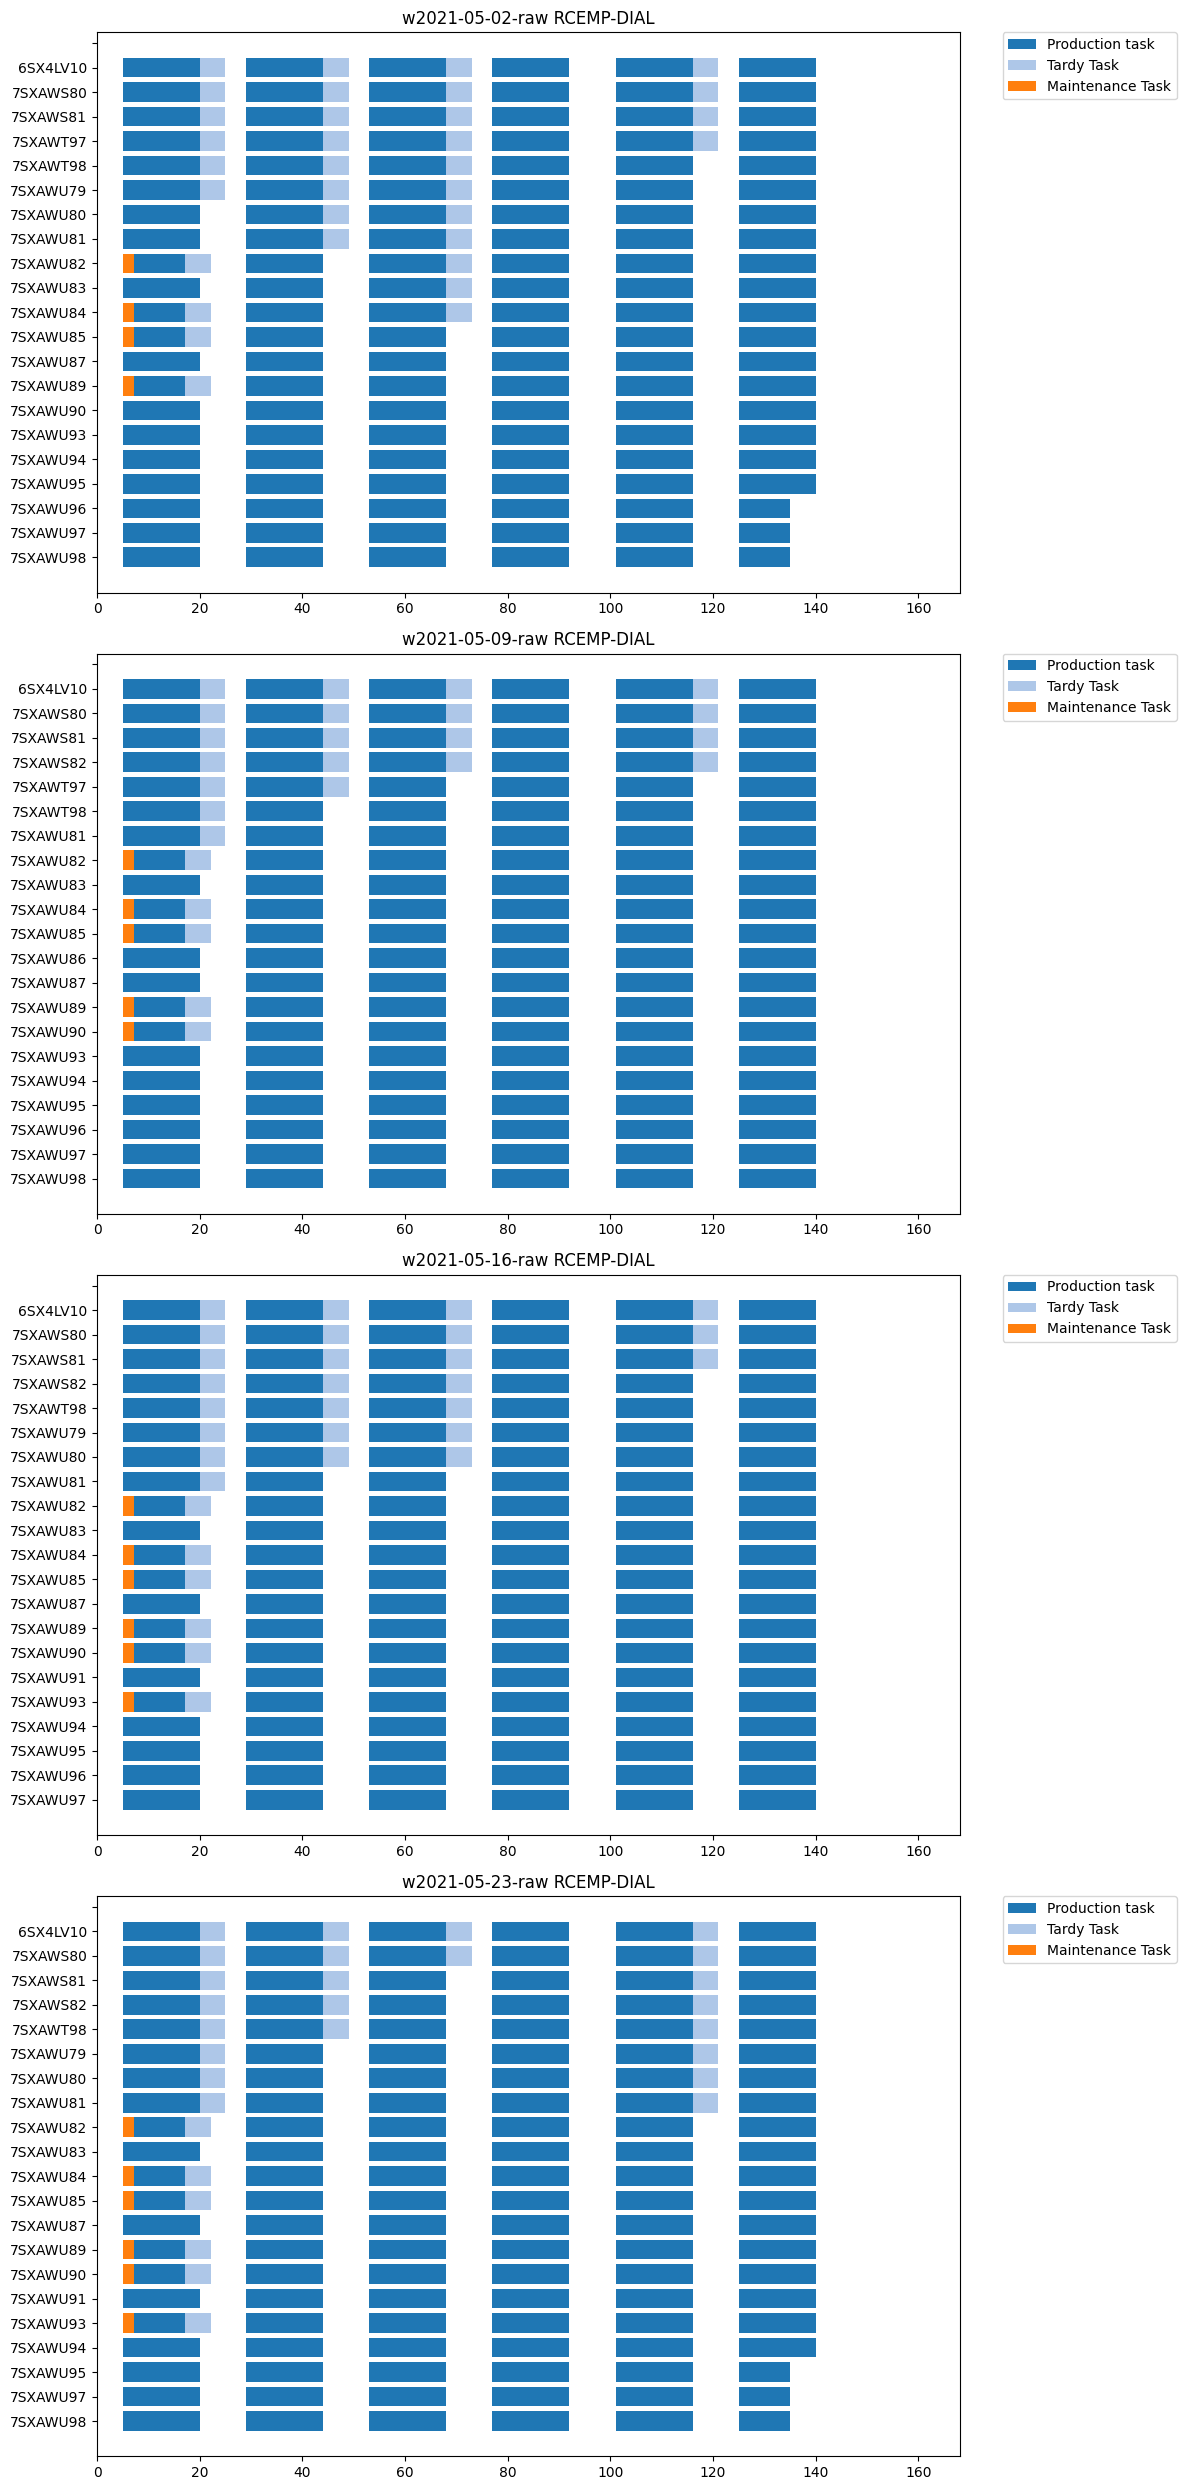

In [5]:
f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
ganttview.plot('w2021-05%raw', '%CEMP%', time_window=(0, 168), title_format=f)

In [6]:
# var_names = prod_var_names + maint_var_names + exec_var_names
# statsview.test(var_names, problem_filter='%', save_as='test_performances.csv')

## identification des periodes

In [7]:
benchmarkname = 'HGD_dialysis_2018_2021'
benchmarkdir = os.path.join(DATA_DIR, 'raw', benchmarkname)
patients_path = os.path.join(benchmarkdir, 'echantillons_patients.csv')
patients_sample = pd.read_csv(patients_path)
patients_sample.head()

,Date,number,day,release_date,due_date,duration,period,instance
0,2020-11-02,71,1,5,20,5,2020-11-08,w2020-11-08-raw
1,2020-11-03,68,2,5,20,5,2020-11-08,w2020-11-08-raw
2,2020-11-04,58,3,5,20,5,2020-11-08,w2020-11-08-raw
3,2020-11-05,66,4,5,20,5,2020-11-08,w2020-11-08-raw
4,2020-11-06,68,5,5,20,5,2020-11-08,w2020-11-08-raw


In [8]:
patients_sample.dtypes

Date            object
number           int64
day              int64
release_date     int64
due_date         int64
duration         int64
period          object
instance        object
dtype: object

In [9]:
periods = patients_sample['period']
periods = list(set(v for v in periods.to_dict().values()))
periods

['2021-03-14',
 '2020-11-22',
 '2021-05-23',
 '2020-12-20',
 '2020-12-27',
 '2021-02-21',
 '2021-04-18',
 '2021-03-21',
 '2021-05-02',
 '2021-01-03',
 '2021-02-28',
 '2021-02-07',
 '2021-04-11',
 '2021-03-28',
 '2021-01-10',
 '2021-01-31',
 '2021-02-14',
 '2020-11-29',
 '2021-01-24',
 '2021-01-17',
 '2020-11-08',
 '2020-11-15',
 '2021-05-16',
 '2021-05-09',
 '2021-04-25',
 '2021-04-04',
 '2020-12-06',
 '2021-03-07',
 '2020-12-13']

## Calcul des retards reels

In [10]:
datapath = os.path.join(benchmarkdir, 'donnees_seances.csv')
seances = pd.read_csv(datapath, sep=';', index_col='Date', parse_dates=True, dayfirst=True)
seances.head()

,ID,Tour,Patients,Debut,Duree
Date,,,,,
2018-03-26,1,Tour1,21,5,5
2018-03-26,2,Tour2,21,10,5
2018-03-26,3,Tour3,21,15,5
2018-03-26,4,Tour4,8,20,5
2018-03-27,5,Tour1,21,5,5


In [11]:
retards = seances[seances.Tour == 'Tour4']
retards.head()

,ID,Tour,Patients,Debut,Duree
Date,,,,,
2018-03-26,4,Tour4,8,20,5
2018-03-27,8,Tour4,9,20,5
2018-03-28,12,Tour4,5,20,5
2018-03-29,16,Tour4,4,20,5
2018-03-30,20,Tour4,9,20,5


In [12]:
nR = retards['Patients']
R = retards['Patients'] * retards['Duree']
R.name, nR.name = 'R', 'nR'
R, nR = R.astype(int), nR.astype(int)
real_stats = pd.concat([R, nR], axis=1)
real_stats.head()

,R,nR
Date,,
2018-03-26,40,8
2018-03-27,45,9
2018-03-28,25,5
2018-03-29,20,4
2018-03-30,45,9


In [13]:
real_stats_hebdo = real_stats.resample('W').sum()
real_stats_hebdo.reset_index(inplace=True)
real_stats_hebdo = real_stats_hebdo[real_stats_hebdo['Date'].isin(periods)]
real_stats_hebdo.head()

,Date,R,nR
136,2020-11-08,105,21
137,2020-11-15,90,18
138,2020-11-22,80,16
139,2020-11-29,80,16
140,2020-12-06,170,34


In [14]:
real_stats_hebdo['problem'] = real_stats_hebdo['Date'].dt.strftime('w%Y-%m-%d-raw')
real_stats_hebdo.drop(['Date'], axis=1, inplace=True)
real_stats_hebdo.set_index('problem', inplace=True)
real_stats_hebdo.head()

,R,nR
problem,,
w2020-11-08-raw,105,21
w2020-11-15-raw,90,18
w2020-11-22-raw,80,16
w2020-11-29-raw,80,16
w2020-12-06-raw,170,34


In [15]:
real_stats_hebdo.shape

(29, 2)

## Collecte des retards simulees

In [16]:
filter_ = '%raw'
sql = f"""select p.name as problem_name, s.name as var_name, s.value 
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name in ('RCEMP-DIAL')
                and s.name in ('R', 'nR')
                and p.name like '{filter_}'
                order by p.name, s.name, s.value;"""

In [17]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data = statsview.load_results(sql)
data.head()

,problem_name,var_name,value
0,w2021-01-03-raw,nR,37.0
1,w2021-01-03-raw,R,227.1
2,w2021-01-10-raw,nR,53.0
3,w2021-01-10-raw,R,307.1
4,w2021-01-17-raw,nR,58.0


In [18]:
sim_vars = []
indexed_data = data.set_index('problem_name')
for var_name, var_data in indexed_data.groupby('var_name'):
    var = var_data['value']
    var.name = var_name
    sim_vars.append(var)
sim_data_hebdo = pd.concat(sim_vars, axis=1)
sim_data_hebdo.head()

,R,nR
problem_name,,
w2021-01-03-raw,227.1,37.0
w2021-01-10-raw,307.1,53.0
w2021-01-17-raw,332.1,58.0
w2021-01-24-raw,317.1,55.0
w2021-01-31-raw,287.1,49.0


## Comparaison des retards

In [19]:
compared_data = real_stats_hebdo.merge(sim_data_hebdo, left_index=True, right_index=True, suffixes=('_real', '_sim'))
compared_data['delta_R'] = ((compared_data['R_sim']/compared_data['R_real']) - 1) * 100
compared_data['delta_nR'] = ((compared_data['nR_sim']/compared_data['nR_real']) - 1) * 100
compared_data.head(25)

,R_real,nR_real,R_sim,nR_sim,delta_R,delta_nR
w2021-01-03-raw,155,31,227.10,37.0,46.516129,19.354839
w2021-01-10-raw,240,48,307.10,53.0,27.958333,10.416667
w2021-01-17-raw,265,53,332.10,58.0,25.320755,9.433962
w2021-01-24-raw,250,50,317.10,55.0,26.840000,10.000000
w2021-01-31-raw,220,44,287.10,49.0,30.500000,11.363636
w2021-02-07-raw,235,47,235.00,47.0,0.000000,0.000000
w2021-02-14-raw,205,41,229.30,45.0,11.853659,9.756098
w2021-02-21-raw,240,48,264.30,52.0,10.125000,8.333333
w2021-02-28-raw,175,35,199.30,39.0,13.885714,11.428571
w2021-03-07-raw,280,56,342.60,65.0,22.357143,16.071429


In [20]:
15/60

0.25

In [21]:
2*7*24

336

## Calcul des disponibilites reels

In [22]:
def f(t):
    law = {'name':'norm', 'params':{'loc':336, 'scale':120}}
    device = sch.Device(name='1', use_duration=t, law=law)
    phm = sch.PHMModule()
    return phm.rul(device, next=False)

[f(i*100) for i in range(5)]

[0.0025551303304279793,
 0.0246108260876501,
 0.128537149342415,
 0.38208857781104744,
 0.7030985713961488]

In [23]:
import json

FILTER_LAMBDA = 2 * 7 * 24   # 2 weeks
GENERAL_LAMBDA = 365 * 24    # 1 year
FILTER_SIGMA = 120
GENERAL_SIGMA = 240
RISK_THRESHOLD = 0.1 #0.1 0.5 0.9
REPAIR_TIME = 1

In [24]:
GENERAL_LAMBDA

8760

In [25]:
GENERAL_LAMBDA = 5/4.5
GENERAL_LAMBDA

1.1111111111111112

In [26]:
def unavalaibility(row):
    MA = sch.Machine
    Dev = sch.Device
    CM = sch.ProductionCompetency
    FN = sch.Function

    ma = MA(uid=MA.next_uid(), name=row.code)
    cm = CM(uid=CM.next_uid(), activity='soin', capability=1, ressource=ma)
    f11 = FN(uid=FN.next_uid(), name='f1')
    f12 = FN(uid=FN.next_uid(), name='f2')
    f1 = FN(uid=FN.next_uid(), name='F1', competency=cm, machine=ma)
    f1.children.extend([f11, f12])

    param_f = {'loc':FILTER_LAMBDA, 'scale':FILTER_SIGMA}
    param_g = {'loc':GENERAL_LAMBDA, 'scale':GENERAL_SIGMA}
    
    law_f = lambda:json.dumps({'name':'norm', 'params':param_f})
    law_g = lambda:json.dumps({'name':'norm', 'params':param_g})
    # law_g = lambda:json.dumps({'name':'norm', 'params':{'scale':GENERAL_LAMBDA}})
            
    phm = sch.PHMModule(uid=sch.PHMModule.next_uid())
    kwargs = dict(phm_module=phm, machine=ma, repair_time=REPAIR_TIME,
                  risk_threshold=RISK_THRESHOLD,  use_duration=row.final_duration)
    dev1 = Dev(uid=Dev.next_uid(), name='Dv1', repair_skill='R1', json_law=law_g(), **kwargs)
    dev2 = Dev(uid=Dev.next_uid(), name='Dv2', repair_skill='R2', json_law=law_g(), **kwargs)
    dev3 = Dev(uid=Dev.next_uid(), name='Dv3', repair_skill='R3', json_law=law_g(), **kwargs)
    dev4 = Dev(uid=Dev.next_uid(), name='Dv4', repair_skill='R4', json_law=law_g(), **kwargs)
    dev5 = Dev(uid=Dev.next_uid(), name='Dv5', repair_skill='R5', json_law=law_g(), **kwargs)
    dev6 = Dev(uid=Dev.next_uid(), name='Dv6', repair_skill='R6', json_law=law_g(), **kwargs)
    dev7 = Dev(uid=Dev.next_uid(), name='Dv7', repair_skill='R7', json_law=law_g(), **kwargs)
    dev8 = Dev(uid=Dev.next_uid(), name='Dv8', repair_skill='R8', json_law=law_g(), **kwargs)
    dev9 = Dev(uid=Dev.next_uid(), name='Dv9', repair_skill='R9', json_law=law_g(), **kwargs)
    dev10 = Dev(uid=Dev.next_uid(), name='Dv10', repair_skill='R10', json_law=law_f(), **kwargs)
    dev11 = Dev(uid=Dev.next_uid(), name='Dv11', repair_skill='R11', json_law=law_g(), **kwargs)
    dev12 = Dev(uid=Dev.next_uid(), name='Dv12', repair_skill='R12', json_law=law_g(), **kwargs)
    dev13 = Dev(uid=Dev.next_uid(), name='Dv13', repair_skill='R13', json_law=law_g(), **kwargs)
    dev14 = Dev(uid=Dev.next_uid(), name='Dv14', repair_skill='R14', json_law=law_g(), **kwargs)
    dev15 = Dev(uid=Dev.next_uid(), name='Dv15', repair_skill='R15', json_law=law_g(), **kwargs)
    f11.devices.extend([dev1, dev2, dev3, dev4, dev5, dev6])
    f12.devices.extend([dev6, dev7, dev8, dev9, dev10, dev11, dev12, dev13, dev14, dev15])
    return f1.rul(next=False)

In [27]:
1/365*24

0.06575342465753425

In [28]:
MTBF = 365 * 24 * 2
lambda_ = 1/MTBF
lambda_

5.7077625570776254e-05

In [29]:
datapath = os.path.join(benchmarkdir, 'echantillons_machines.csv')
machines = pd.read_csv(datapath, sep=',', index_col=0)
machines.head()

,code,period,use_duration,final_duration,nb_jour,total_pannes,instance
58,7SXAWU81,2020-11-08,1756,2064,7,0,w2020-11-08-raw
87,7SXAWU90,2020-11-08,896,1200,7,0,w2020-11-08-raw
116,7SXAWS81,2020-11-08,8076,8380,7,0,w2020-11-08-raw
145,7SXAWU96,2020-11-08,4836,5140,7,0,w2020-11-08-raw
174,7SXAWU87,2020-11-08,3324,3628,7,0,w2020-11-08-raw


In [30]:
unavail_machines = machines.copy()
unavail_machines['Abar'] = machines.apply(unavalaibility, axis=1)
unavail_machines[unavail_machines['Abar'] < 0.5].head()

,code,period,use_duration,final_duration,nb_jour,total_pannes,instance,Abar
204,7SXAWT98,2020-11-15,0,300,7,0,w2020-11-15-raw,0.070566
236,7SXAWU86,2020-12-06,228,396,3,0,w2020-12-06-raw,0.320618
352,7SXAWU94,2020-12-06,0,152,4,3,w2020-12-06-raw,0.000621
266,7SXAWU97,2020-12-13,104,424,7,0,w2020-12-13-raw,0.422844
469,7SXAWU80,2020-12-13,48,360,7,0,w2020-12-13-raw,0.203349


In [31]:
no_cols = ['use_duration', 'final_duration', 'code', 'period', 'nb_jour', 'total_pannes']
unavail_reel = unavail_machines.drop(no_cols, axis=1).groupby('instance').aggregate(np.product)
# unavail_reel['Abar'] = 1 - unavail_reel['Abar']
unavail_reel.head()

,Abar
instance,
w2020-11-08-raw,0.999989
w2020-11-15-raw,0.070566
w2020-11-22-raw,0.911305
w2020-11-29-raw,0.998894
w2020-12-06-raw,0.000194


## Collecte des disponibilites simulees

In [32]:
sql = f"""select p.name as problem_name, s.name as var_name, s.value * 100000 as value
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name in ('RCEMP-DIAL')
                and s.name = 'Abar'
                and p.name like '%raw'
                order by p.name, s.name, s.value;"""

In [33]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data = statsview.load_results(sql)
data.head()

,problem_name,var_name,value
0,w2021-01-03-raw,Abar,0.0
1,w2021-01-10-raw,Abar,0.0
2,w2021-01-17-raw,Abar,0.0
3,w2021-01-24-raw,Abar,0.0
4,w2021-01-31-raw,Abar,0.0


In [34]:
unavail_sim = data.copy()
unavail_sim['Abar'] = unavail_sim['value']
unavail_sim.drop(['var_name', 'value'], axis=1, inplace=True)
unavail_sim.set_index('problem_name', inplace=True)
unavail_sim

,Abar
problem_name,
w2021-01-03-raw,0.0
w2021-01-10-raw,0.0
w2021-01-17-raw,0.0
w2021-01-24-raw,0.0
w2021-01-31-raw,0.0
w2021-02-07-raw,0.0
w2021-02-14-raw,0.0
w2021-02-21-raw,0.0
w2021-02-28-raw,0.0


## Comparaison des disponibilites

In [35]:
unavail_reel.merge(unavail_sim, left_index=True, right_index=True, suffixes=('_real', '_sim'))

,Abar_real,Abar_sim
w2021-01-03-raw,0.850513,0.0
w2021-01-10-raw,0.998646,0.0
w2021-01-17-raw,0.999998,0.0
w2021-01-24-raw,1.000000,0.0
w2021-01-31-raw,0.113211,0.0
w2021-02-07-raw,0.374058,0.0
w2021-02-14-raw,0.365313,0.0
w2021-02-21-raw,0.069656,0.0
w2021-02-28-raw,0.943643,0.0
w2021-03-07-raw,0.999765,0.0


In [36]:
compared_unavail = unavail_reel.merge(unavail_sim, left_index=True, right_index=True, suffixes=('_real', '_sim'))
compared_unavail['delta_Abar'] = compared_unavail['Abar_sim']-compared_unavail['Abar_real']
compared_unavail

,Abar_real,Abar_sim,delta_Abar
w2021-01-03-raw,0.850513,0.0,-0.850513
w2021-01-10-raw,0.998646,0.0,-0.998646
w2021-01-17-raw,0.999998,0.0,-0.999998
w2021-01-24-raw,1.000000,0.0,-1.000000
w2021-01-31-raw,0.113211,0.0,-0.113211
w2021-02-07-raw,0.374058,0.0,-0.374058
w2021-02-14-raw,0.365313,0.0,-0.365313
w2021-02-21-raw,0.069656,0.0,-0.069656
w2021-02-28-raw,0.943643,0.0,-0.943643
w2021-03-07-raw,0.999765,0.0,-0.999765
